In [1]:
# Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib import rcParams
from scipy.optimize import minimize
from matplotlib.dates import DateFormatter, MonthLocator

# Analysis of environmental data
Data was collected from the (Lifewatch data explorer)[https://rshiny.lifewatch.be/station-data/], and reviewed by the head scientists of the project. We only retained the data that was collected on sampling events for which we have metatranscriptomic data. 

## Data loading & preprocessing

In [2]:
lifewatch_data = pd.read_excel('../../data/environmental/Lifewatch_environmental.xlsx')
lifewatch_data.head()

,TripStationNR,datetime,date,Code,19'-Butanoyloxyfucoxanthin (µg/l),19'-Hexanoyloxyfucoxanthin (µg/l),Alloxanthin (µg/l),Antheraxanthin (µg/l),Astaxanthine (µg/l),Chlorophyll a (µg/L),...,Secchi depth (cm),CTD > Conductivity,CTD > Density,CTD > Fluorescence,CTD > OBS,CTD > PAR,CTD > Pressure,CTD > Salinity,CTD > Sound Velocity,CTD > Temperature
0,20779,NaT,2020 06,120,0.00000,0.047472,0.052742,0.000000,0.000000,7.682503,...,220.0,44136.571429,1024.136357,25.683267,2.750714,1.000000e-12,3.513095,33.496900,1514.143333,18.001105
1,20780,NaT,2020 06,130,0.04469,0.000000,0.158064,0.085299,0.076385,18.334460,...,60.0,42597.555556,1022.886367,54.296444,37.893778,1.000000e-12,3.683556,31.957889,1513.286667,18.302811
2,20781,NaT,2020 06,215,0.00000,0.000000,0.066942,0.015981,0.000000,6.566381,...,420.0,43243.428571,1023.732457,15.658714,0.997486,1.000000e-12,3.519286,32.904464,1512.866429,17.796457
3,20782,NaT,2020 06,230,0.00000,0.015020,0.069479,0.020778,0.011458,8.300763,...,160.0,42981.666667,1023.488300,24.799517,4.739867,1.000000e-12,3.603583,32.612267,1512.793333,17.883558
4,20783,NaT,2020 06,330,0.00000,0.000000,0.219081,0.000000,0.000000,8.326106,...,420.0,42391.062500,1023.626569,15.419031,0.686388,1.000000e-12,3.554813,32.601462,1510.953125,17.269419


In [3]:
print(lifewatch_data.columns)

Index(['TripStationNR', 'datetime', 'date', 'Code',
       '19'-Butanoyloxyfucoxanthin (µg/l)',
       '19'-Hexanoyloxyfucoxanthin (µg/l)', 'Alloxanthin (µg/l)',
       'Antheraxanthin (µg/l)', 'Astaxanthine (µg/l)', 'Chlorophyll a (µg/L)',
       'Chlorophyll b (µg/L)', 'Chlorophyll c2 (+c1) (µg/L)',
       'Chlorophyll c3 (µg/l)', 'Chlorophyllide a (µg/L)',
       'Diadinoxanthin (µg/l)', 'Diatoxanthin (µg/l)', 'Echinenone (µg/l)',
       'Fucoxanthin (µg/l)', 'Lutein (µg/L)', 'Neoxanthin (µg/l)',
       'Peridinin (µg/l)', 'Pheophorbide a (µg/l)', 'Pheophytin a (µg/l)',
       'Prasinoxanthin (µg/l)', 'Violaxanthin (µg/l)', 'Zeaxanthin (µg/l)',
       'β,β-Carotene (µg/l)',
       'Nitraat - Nitriet (Nox): Molar conc (µmol N-Nox/L)',
       'Nitraat (NO3) Molar conc: (µmol N-NO3/L)',
       'Nitriet (NO2) Molar conc: (µmol N-NO2/L)',
       'Phosphate (PO4): Molar conc (µmol P-PO4/L)',
       'Silicaat (Si): Molar conc (µmol Si-SiO2/L)',
       'Ammonium (NH4): Molar conc (µmol N-NH

In [4]:
# Some of these column names are inconvenient to work with, so we'll rename them
lifewatch_data.columns = ['TripStationNR',
                          'Datetime', 'Date', 'Station',
                          'Butanoyloxyfucoxanthin',
                          'Hexanoyloxyfucoxanthin',
                          'Alloxanthin',
                          'Antheraxanthin',
                          'Astaxanthine', 
                          'Chlorophyll_a',
                          'Chlorophyll_b',
                          'Chlorophyll_c2_(+c1)',
                          'Chlorophyll_c3',
                          'Chlorophyllide_a',
                          'Diadinoxanthin',
                          'Diatoxanthin',
                          'Echinenone',
                          'Fucoxanthin',
                          'Lutein',
                          'Neoxanthin',
                          'Peridinin', 
                          'Pheophorbide_a',
                          'Pheophytin_a',
                          'Prasinoxanthin',
                          'Violaxanthin',
                          'Zeaxanthin',
                          'β_β_Carotene',
                          'Nitrate_Nitrite',
                          'Nitrate',
                          'Nitrite',
                          'Phosphate',
                          'Silicate',
                          'Ammonium', 
                          'SPM',
                          'Secchi',
                          'Conductivity',
                          'Density',
                          'Fluorescence',
                          'OBS',
                          'PAR',
                          'Pressure', 
                          'Salinity',
                          'Sound_Velocity',
                          'Temperature']


# Fix station column trailing spaces
lifewatch_data['Station'] = lifewatch_data['Station'].str.strip()

In [5]:
# Only retain months for which we have MTX data
print(lifewatch_data['Date'].unique())

# For some months included we don't have MTX data, so we'll remove them
lifewatch_data = lifewatch_data[~lifewatch_data['Date'].isin(['2020 06', '2021 03'])]

# Only retain relevant stations
lifewatch_data = lifewatch_data[lifewatch_data['Station'].isin(['ZG02', '120', '330', '130', '780', '700'])]

# Rows with values below 0 in columns of interest should be 0
columns_of_interest = ['Nitrate',  'Nitrite', 'Phosphate','Silicate','Ammonium', 'SPM', 'Salinity', 'Temperature']
lifewatch_data[columns_of_interest] = lifewatch_data[columns_of_interest].clip(lower=0)

['2020 06' '2020 07' '2020 08' '2020 09' '2020 11' '2020 12' '2021 01'
 '2021 02' '2021 03' '2021 04' '2021 05' '2021 06' '2021 07']


In [6]:
# Add oxygen data
data_oxygen = pd.read_csv('../../data/environmental/Lifewatch_oxygen.csv')
print(len(data_oxygen))

# Specify columns of interest
columns_of_interest = ['TripStationNR', 'MeanOxygen']

# Merge with lifewatch data
print(len(lifewatch_data))
lifewatch_data = lifewatch_data.merge(data_oxygen[columns_of_interest], on=['TripStationNR'], how='left')
print(len(lifewatch_data))

2723
63
63


## Summarize

In [7]:
# Prepare data for analysis
columns_to_describe = ['Temperature', 'Salinity', 'Nitrate', 'Nitrite', 'Phosphate','Silicate','Ammonium', 'SPM', 'Secchi', 'Conductivity', 'Density', 'Fluorescence', 'OBS', 'PAR', 'Pressure', 'MeanOxygen']
lifewatch_data_summarized = lifewatch_data[columns_to_describe + ['Date', 'Station']].copy()
# Ensure 'Date' is in datetime format
lifewatch_data_summarized['Date'] = pd.to_datetime(lifewatch_data_summarized['Date'])

# Create 'Location' column
lifewatch_data_summarized['Location'] = lifewatch_data_summarized['Station'].apply(lambda x: 'nearshore' if x in ['120', '130', '700'] else 'offshore')

# Function to calculate mean, standard deviation, range and dates when these extremes are reached
def describe_data(df):
    desc = pd.DataFrame()

    for col in df.columns:
        if col not in ['Date', 'Station', 'Location']:
            temp_df = df[[col, 'Date', 'Location']].dropna()
            desc.loc[col, 'mean'] = temp_df[col].mean().round(2)
            desc.loc[col, 'std_dev'] = temp_df[col].std().round(2)
            desc.loc[col, 'min'] = temp_df[col].min().round(2)
            # Indicate the month when the minimum value was reached
            desc.loc[col, 'min_date'] = temp_df.loc[temp_df[col].idxmin(), 'Date'].strftime('%Y-%m')
            desc.loc[col, 'max'] = temp_df[col].max().round(2)
            desc.loc[col, 'max_date'] = temp_df.loc[temp_df[col].idxmax(), 'Date'].strftime('%Y-%m')
            desc.loc[col, 'missing_data'] = df[col].isnull().sum()
            # Skip column if it has more than half of its data missing
            if desc.loc[col, 'missing_data'] > len(df)/2:
                desc.drop(col, inplace=True)
    return desc

# Describe overall data
overall_desc = describe_data(lifewatch_data_summarized)

# Describe nearshore data
nearshore_desc = describe_data(lifewatch_data_summarized[lifewatch_data_summarized['Location'] == 'nearshore'])

# Describe offshore data
offshore_desc = describe_data(lifewatch_data_summarized[lifewatch_data_summarized['Location'] == 'offshore'])

# Print summarized data
print("Overall Summary:")
print(overall_desc)
print("\nNearshore Summary:")
print(nearshore_desc)
print("\nOffshore Summary:")
print(offshore_desc)

# Save summarized data to excel
overall_desc.to_excel('../../data/environmental/Lifewatch_environmental_summarized.xlsx')
nearshore_desc.to_excel('../../data/environmental/Lifewatch_environmental_summarized_nearshore.xlsx')
offshore_desc.to_excel('../../data/environmental/Lifewatch_environmental_summarized_offshore.xlsx')

Overall Summary:
                  mean  std_dev       min min_date       max max_date  \
Temperature      12.34     5.96      2.17  2021-02     22.54  2020-08   
Salinity         32.99     1.35     29.92  2021-02     34.73  2020-11   
Nitrate          12.45    13.68      0.25  2021-06     57.82  2021-02   
Nitrite           0.43     0.36      0.03  2021-02      1.54  2020-09   
Phosphate         0.41     0.39      0.00  2021-06      1.40  2021-02   
Silicate          7.40     9.29      0.00  2020-11     43.86  2021-02   
SPM              50.18    58.07      9.00  2021-05    340.00  2021-01   
Secchi          213.15   176.79     20.00  2020-12    750.00  2020-08   
Conductivity  38406.06  5926.06  26908.09  2021-02  49032.53  2020-08   
Density        1024.81     1.39   1022.05  2021-06   1026.98  2021-02   
Fluorescence     24.26    28.14      5.12  2021-05    123.10  2021-04   
OBS              11.74    19.27      0.49  2021-05    108.98  2021-01   
PAR            2352.71  4283.60   

## Plot

In [8]:
# Set font to the one used in the manuscript
sns.set(font_scale=1, style="whitegrid", font="Times New Roman")

def LinePlotEnvironmentalDataTimeSeriesFacetted(data, parameter, outfolder, colors):
    '''
    A function that creates publication-ready line plots from pigment data taken at a certain station.
    The measured value over time of a certain parameter is plotted, with every station a line.
    Two plots are made: coastal and offshore.
    '''
    # Check if the output folder exists, and create it if it does not
    if not os.path.exists(outfolder):
        os.makedirs(outfolder)
    
    # Set font and size
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
    rcParams['font.size'] = 8

    # Set style
    sns.set_style("whitegrid", {
        "axes.grid": True,
        "grid.color": ".9",
        "grid.linestyle": "-",
        "axes.hlines": True,
        "grid.linewidth": 0.4
    })
        
    # Create term for unit conversion
    cm = 1/2.54
    
    # Create the plot
    # Create grid based on the 'location' column
    g = sns.FacetGrid(data, col="location", hue='Station', palette=colors, height=9*cm, aspect=1)
    
    # Map the lineplot onto the grid
    g.map(plt.plot, 'Datetime', parameter, marker='o', markersize=8, linewidth=1.8)

    # Set the x-axis properties
    date_format = DateFormatter("%b %Y")
    min_date = data['Datetime'].min().replace(day=1)
    max_date = (data['Datetime'].max() + pd.DateOffset(months=1)).replace(day=1)

    for ax in g.axes.flat:
        ax.set_xlim(min_date, max_date)
        ax.xaxis.set_major_locator(MonthLocator())
        ax.xaxis.set_major_formatter(date_format)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
    
    # Show the plot and save it
    plt.savefig((outfolder + f'{parameter}.svg'), dpi=600, bbox_inches='tight')
    plt.show()
    
    # return g

### Abiotic variables

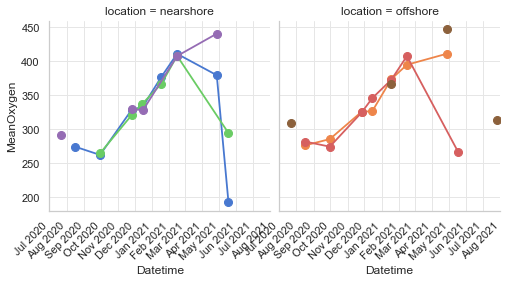

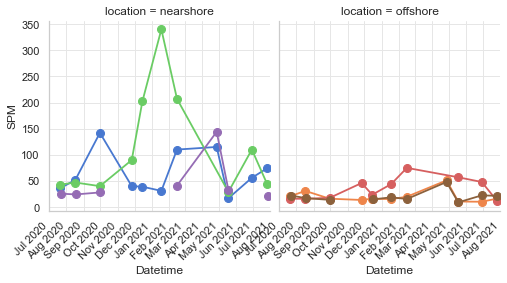

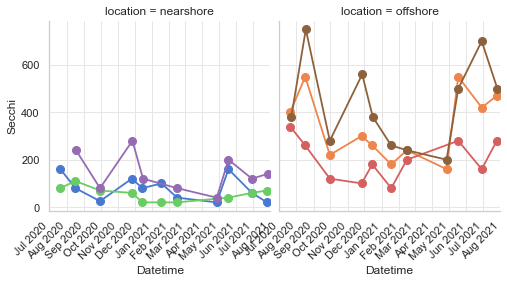

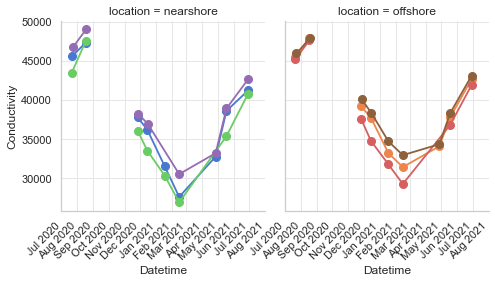

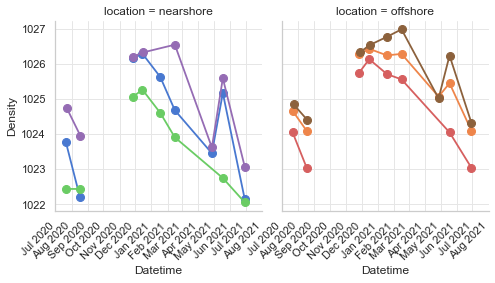

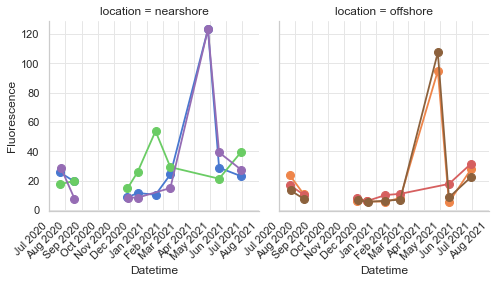

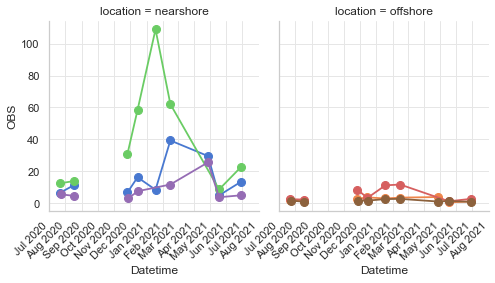

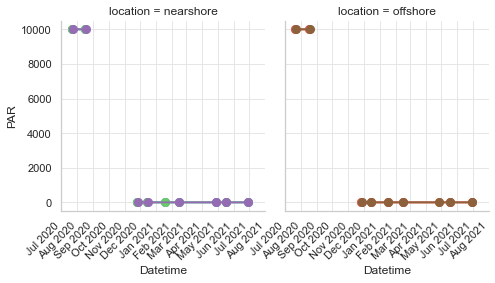

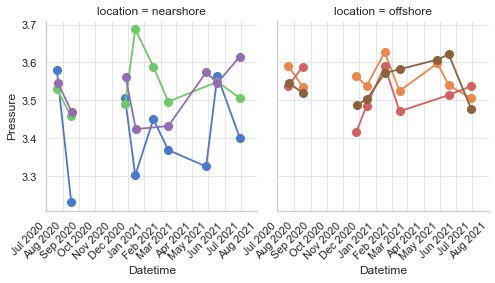

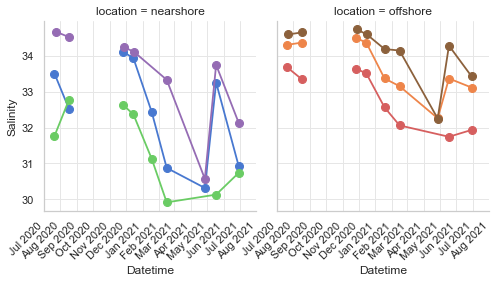

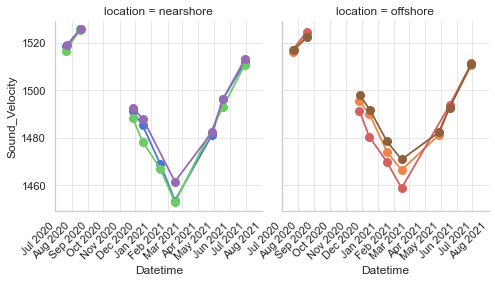

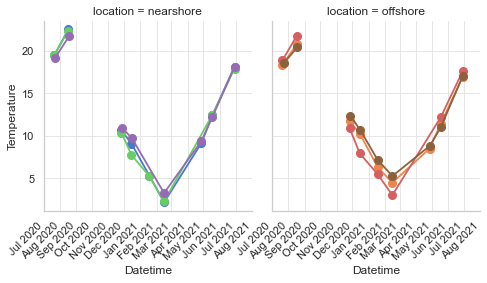

In [9]:
abiotic_data = ['MeanOxygen', 'SPM', 'Secchi', 'Conductivity', 'Density', 'Fluorescence', 'OBS', 'PAR', 'Pressure', 'Salinity', 'Sound_Velocity', 'Temperature']

# Add a column to the dataframe that indicates whether a station is coastal or offshore
lifewatch_data['location'] = lifewatch_data['Station'].apply(lambda x: 'nearshore' if x in ['120', '130', '700'] else 'offshore')

colors = sns.color_palette('muted', n_colors = 6)

#colors = ['#1F618D', '#2980B9', '#7FB3D5', '#117A65', '#16A085', '#73C6B6']
#sns.set_palette(sns.color_palette(colors))

# Plot abiotic data for coastal stations
outfolder = '../../figures/environmental/abiotic/location/'
for column in abiotic_data:
    LinePlotEnvironmentalDataTimeSeriesFacetted(lifewatch_data, column, outfolder, colors);

Now let's get average values and standard deviations of the data.

In [10]:
def get_parameter_mean(data, parameter, location):
    if location == 'all':
        return data[parameter].mean()
    return data[data['location'] == location][parameter].mean()
    
def get_parameter_sd(data, parameter, location):
    if location == 'all':
        return data[parameter].std()
    return data[data['location'] == location][parameter].std()

def get_parameter_min(data, parameter, location):
    if location == 'all':
        return data[parameter].min()
    return data[data['location'] == location][parameter].min()

def get_parameter_max(data, parameter, location):
    if location == 'all':
        return data[parameter].max()
    return data[data['location'] == location][parameter].max()

In [11]:
# print average and standard deviation of abiotic data for coastal and offshore stations
parameters_of_interest = ['Salinity', 'Temperature', 'SPM']
for parameter in parameters_of_interest:
    avg = get_parameter_mean(lifewatch_data, parameter, 'all')
    sd = get_parameter_sd(lifewatch_data, parameter, 'all')
    min = get_parameter_min(lifewatch_data, parameter, 'all')
    max = get_parameter_max(lifewatch_data, parameter, 'all')
    print(f'{parameter} average: {avg:.2f} +/- {sd:.2f}')
    print(f'{parameter} minimum: {min:.2f} maximum: {max:.2f}')
    for location in ['coastal', 'offshore']:
        avg = get_parameter_mean(lifewatch_data, parameter, location)
        sd = get_parameter_sd(lifewatch_data, parameter, location)
        min = get_parameter_min(lifewatch_data, parameter, location)
        max = get_parameter_max(lifewatch_data, parameter, location)
        print(f'{parameter} {location} average: {avg:.2f} +/- {sd:.2f} SD')
        print(f'{parameter} {location} minimum: {min:.2f} maximum: {max:.2f}')

Salinity average: 32.99 +/- 1.35
Salinity minimum: 29.92 maximum: 34.73
Salinity coastal average: nan +/- nan SD
Salinity coastal minimum: nan maximum: nan
Salinity offshore average: 33.54 +/- 0.93 SD
Salinity offshore minimum: 31.74 maximum: 34.73
Temperature average: 12.34 +/- 5.96
Temperature minimum: 2.17 maximum: 22.54
Temperature coastal average: nan +/- nan SD
Temperature coastal minimum: nan maximum: nan
Temperature offshore average: 12.22 +/- 5.59 SD
Temperature offshore minimum: 3.02 maximum: 21.76
SPM average: 50.18 +/- 58.07
SPM minimum: 9.00 maximum: 340.00
SPM coastal average: nan +/- nan SD
SPM coastal minimum: nan maximum: nan
SPM offshore average: 25.10 +/- 16.46 SD
SPM offshore minimum: 9.00 maximum: 75.00


### nutrient concentrations

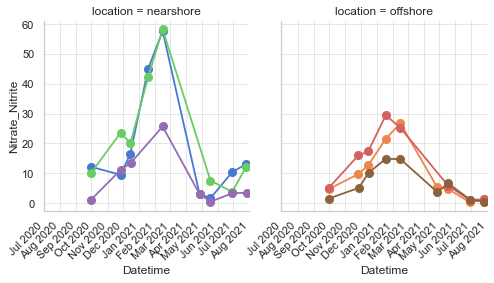

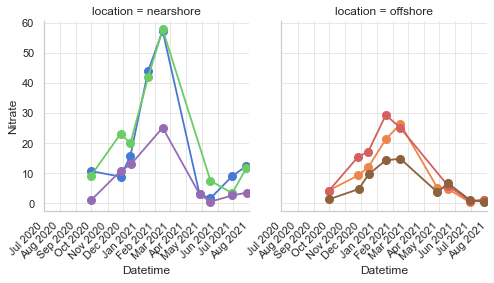

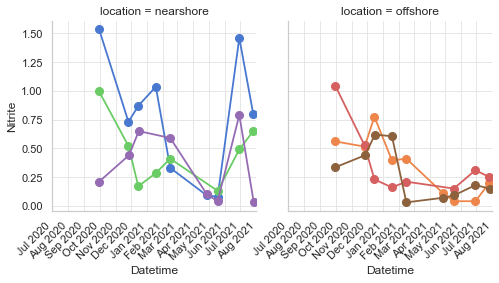

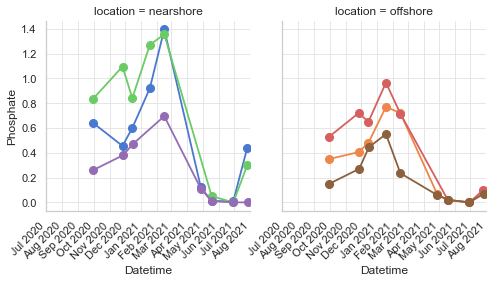

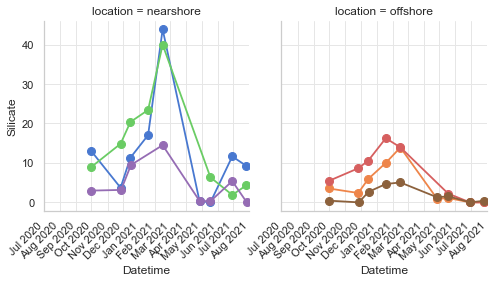

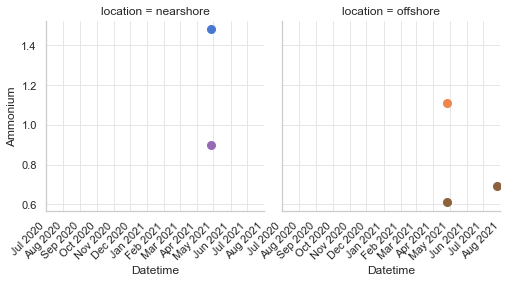

In [12]:
nutrient_data = ['Nitrate_Nitrite', 'Nitrate', 'Nitrite', 'Phosphate', 'Silicate', 'Ammonium']
outfolder = '../../figures/environmental/nutrients/location/'

for column in nutrient_data:
    LinePlotEnvironmentalDataTimeSeriesFacetted(lifewatch_data, column, outfolder, colors)

In [13]:
# print average and standard deviation of nutrient data for coastal and offshore stations
parameters_of_interest = ['Nitrate', 'Phosphate', 'Silicate']
for parameter in parameters_of_interest:
    avg = get_parameter_mean(lifewatch_data, parameter, 'all')
    sd = get_parameter_sd(lifewatch_data, parameter, 'all')
    min = get_parameter_min(lifewatch_data, parameter, 'all')
    max = get_parameter_max(lifewatch_data, parameter, 'all')
    print(f'{parameter} average: {avg:.2f} +/- {sd:.2f}')
    print(f'{parameter} minimum: {min:.2f} maximum: {max:.2f}')
    for location in ['coastal', 'offshore']:
        avg = get_parameter_mean(lifewatch_data, parameter, location)
        sd = get_parameter_sd(lifewatch_data, parameter, location)
        min = get_parameter_min(lifewatch_data, parameter, location)
        max = get_parameter_max(lifewatch_data, parameter, location)
        print(f'{parameter} {location} average: {avg:.2f} +/- {sd:.2f} SD')
        print(f'{parameter} {location} minimum: {min:.2f} maximum: {max:.2f}')

Nitrate average: 12.45 +/- 13.68
Nitrate minimum: 0.25 maximum: 57.81
Nitrate coastal average: nan +/- nan SD
Nitrate coastal minimum: nan maximum: nan
Nitrate offshore average: 9.19 +/- 8.74 SD
Nitrate offshore minimum: 0.25 maximum: 29.32
Phosphate average: 0.41 +/- 0.39
Phosphate minimum: 0.00 maximum: 1.40
Phosphate coastal average: nan +/- nan SD
Phosphate coastal minimum: nan maximum: nan
Phosphate offshore average: 0.32 +/- 0.30 SD
Phosphate offshore minimum: 0.00 maximum: 0.96
Silicate average: 7.40 +/- 9.29
Silicate minimum: 0.00 maximum: 43.87
Silicate coastal average: nan +/- nan SD
Silicate coastal minimum: nan maximum: nan
Silicate offshore average: 4.26 +/- 4.96 SD
Silicate offshore minimum: 0.00 maximum: 16.26


### pigment concentrations

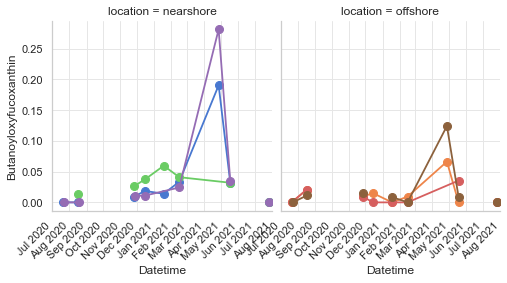

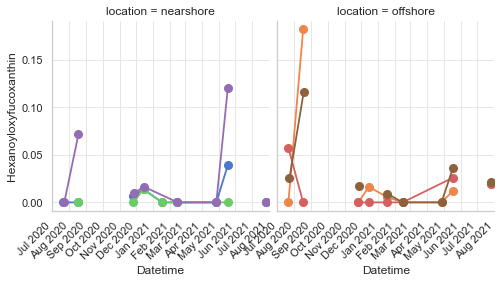

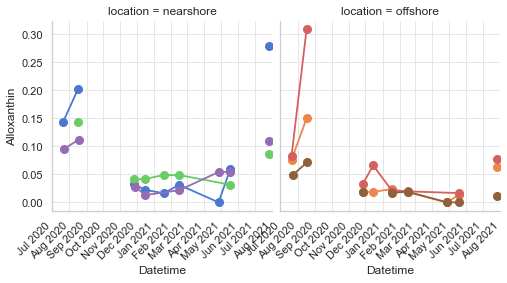

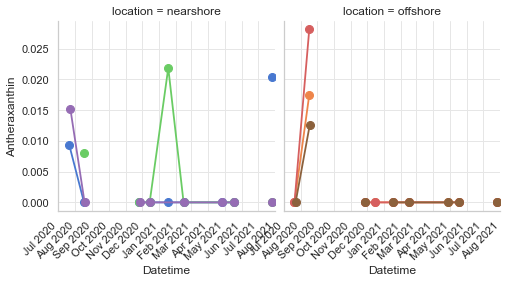

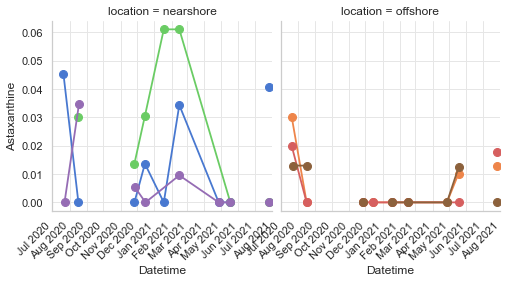

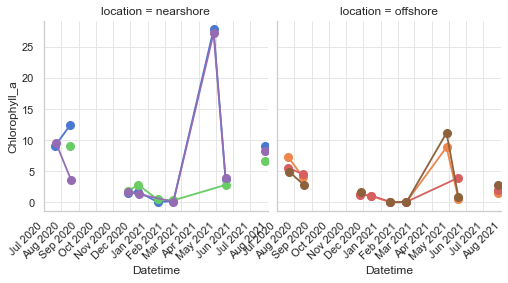

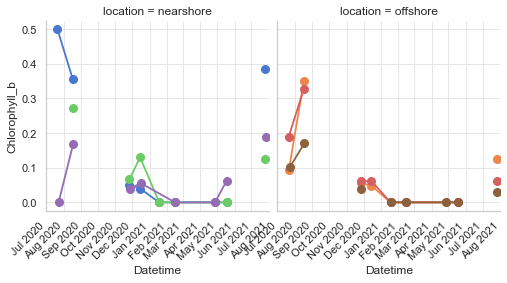

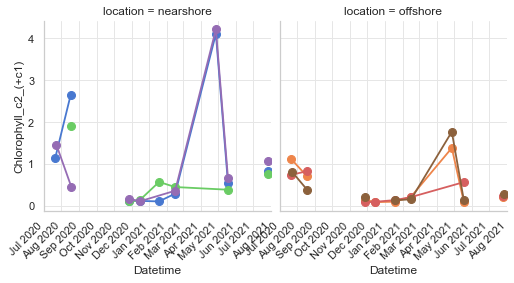

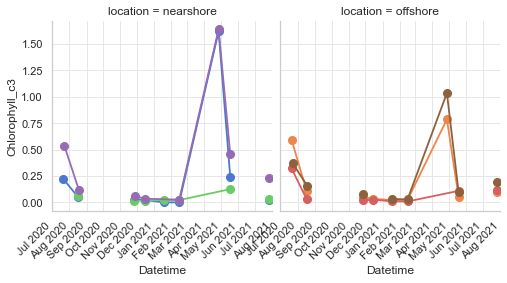

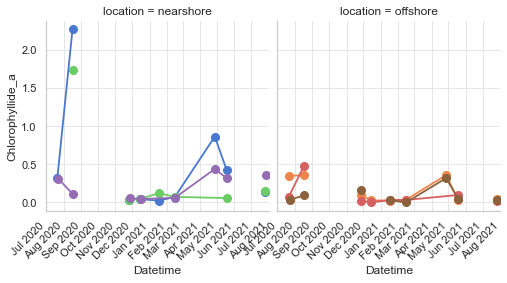

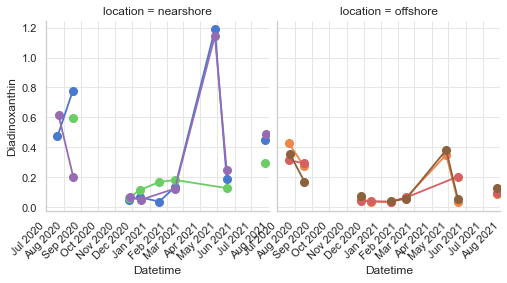

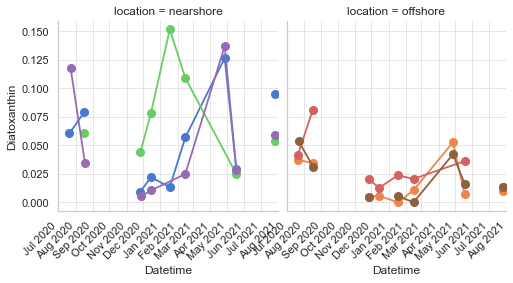

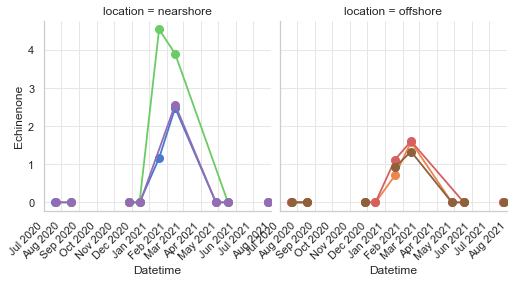

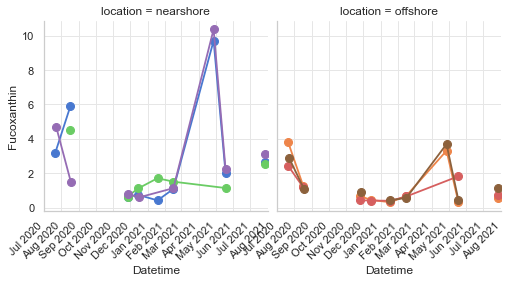

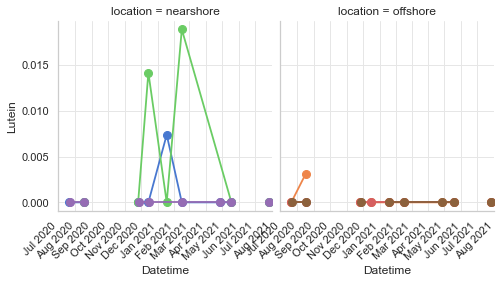

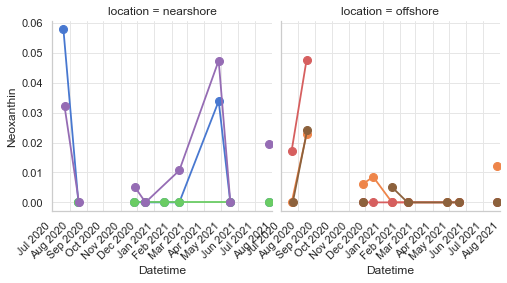

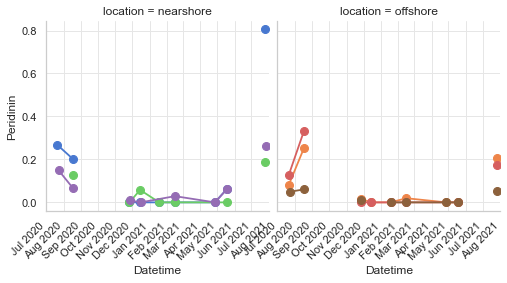

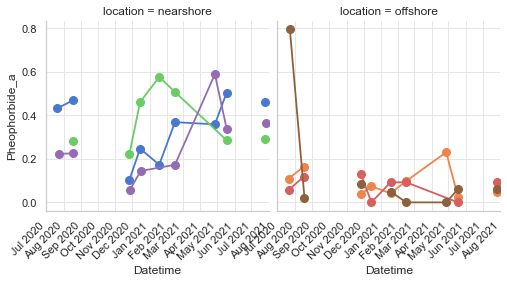

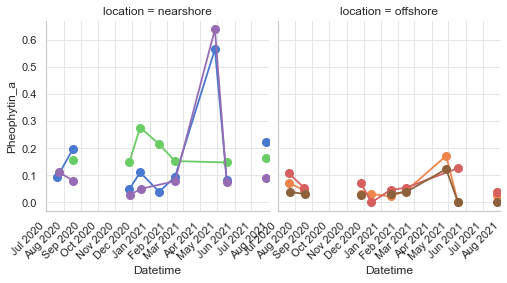

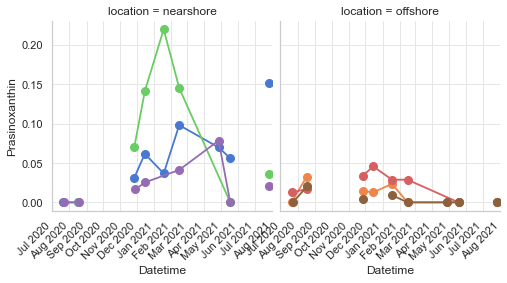

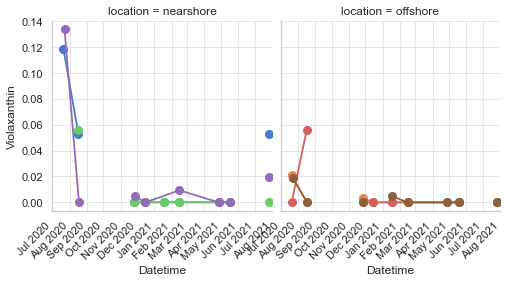

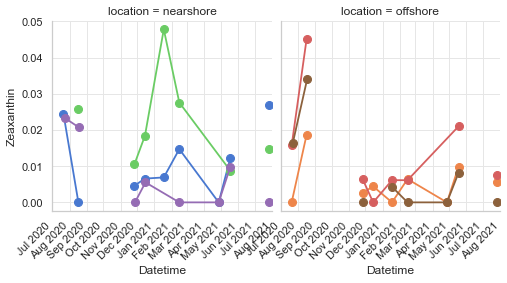

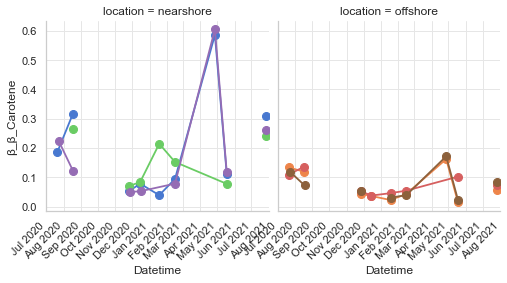

In [14]:
abiotic_data = ['Butanoyloxyfucoxanthin','Hexanoyloxyfucoxanthin','Alloxanthin','Antheraxanthin','Astaxanthine', 'Chlorophyll_a','Chlorophyll_b','Chlorophyll_c2_(+c1)','Chlorophyll_c3','Chlorophyllide_a','Diadinoxanthin','Diatoxanthin','Echinenone','Fucoxanthin','Lutein','Neoxanthin','Peridinin', 'Pheophorbide_a','Pheophytin_a','Prasinoxanthin','Violaxanthin','Zeaxanthin','β_β_Carotene']
outfolder = '../../figures/environmental/pigments/location/'

for column in abiotic_data:
    LinePlotEnvironmentalDataTimeSeriesFacetted(lifewatch_data, column, outfolder, colors)

### pigment analysis (CHEMTAX)

In [15]:
# Create initial ratios DataFramez
## Used the same table as Muylaert et al., 2006
ratios = pd.DataFrame({
    'Chlorophytes': [0, 0, 0, 0, 0.058, 0.034, 0.240],
    'Cyanobacteria': [0, 0, 0, 0, 0, 0.232, 0],
    'Diatoms': [0, 0.378, 0, 0.043, 0, 0, 0],
    'Dinoflagellates': [0.366, 0, 0, 0.152, 0, 0, 0],
    'Euglenophytes': [0, 0, 0, 0.137, 0, 0, 0.277],
    'Phaeocystis': [0, 0.387, 0.075, 0.013, 0, 0, 0]
}, index=['Peridinin', 'Fucoxanthin', 'Chlorophyll c3', 'Diatoxanthin + diadinoxanthin', 'Lutein', 'Zeaxanthin', 'Chlorophyll b'])

def objective(x, ratios, observed):
    calculated = x @ ratios.T
    return ((observed - calculated) ** 2).sum()

# Load observed data, i.e. the pigment ratios of the samples that are also in the ratios DataFrame
observed = lifewatch_data[['Date', 'Station','Peridinin', 'Fucoxanthin', 'Chlorophyll_c3', 'Diatoxanthin', 'Diadinoxanthin', 'Lutein', 'Zeaxanthin', 'Chlorophyll_b']].copy()
# Paste Date and Station together to create index
observed['sample'] = observed['Date'] + ' ' + observed['Station']
# Swap spaces to underscores in the sample names
observed['sample'] = observed['sample'].str.replace(' ', '_')
# Create index from date and station
observed.set_index(['sample'], inplace=True)
# Drop date and station columns
observed.drop(columns=['Date', 'Station'], inplace=True)

# Merge Diatoxanthin and Diadinoxanthin into one column, summing the values
observed['Diatoxanthin + diadinoxanthin'] = observed['Diatoxanthin'] + observed['Diadinoxanthin']
# Drop the original columns
observed.drop(columns=['Diatoxanthin', 'Diadinoxanthin'], inplace=True)

# Rename columns to match ratio names in ratios DataFrame
observed.rename(columns={'Chlorophyll_c3': 'Chlorophyll c3', 'Chlorophyll_b': 'Chlorophyll b'}, inplace=True)
# Drop rows with NaN values
observed.dropna(inplace=True)

# Initial guess
x0 = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]  # Assuming equal proportions to start

# Constraints: proportions must sum to 1
constraints = {'type': 'eq', 'fun': lambda x: 1 - sum(x)}

# Bounds: proportions must be between 0 and 1
bounds = [(0, 1) for _ in x0]

# Optimize for each sample separately
results = {}
for i, obs in observed.iterrows():
    res = minimize(objective, x0, args=(ratios, obs), constraints=constraints, bounds=bounds, method='SLSQP')
    results[i] = res.x

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results, index=ratios.columns).T

print(results_df)


              Chlorophytes  Cyanobacteria       Diatoms  Dinoflagellates  \
2020_07_130   0.000000e+00   0.000000e+00  6.494805e-15     0.000000e+00   
2020_07_330   0.000000e+00   0.000000e+00  6.369905e-15     0.000000e+00   
2020_07_780   2.730811e-15   1.911742e-15  0.000000e+00     1.227003e-15   
2020_07_120   0.000000e+00   0.000000e+00  3.820555e-14     0.000000e+00   
2020_07_ZG02  1.167110e-15   2.715901e-16  0.000000e+00     0.000000e+00   
2020_08_120   7.138635e-16   2.544792e-16  0.000000e+00     2.410169e-16   
2020_08_ZG02  3.512662e-16   0.000000e+00  0.000000e+00     5.878076e-18   
2020_08_130   4.849739e-15   4.097284e-15  0.000000e+00     4.173358e-15   
2020_08_700   0.000000e+00   0.000000e+00  2.053913e-14     0.000000e+00   
2020_08_330   0.000000e+00   9.494623e-17  1.110223e-15     1.212769e-16   
2020_08_780   0.000000e+00   0.000000e+00  1.000000e+00     0.000000e+00   
2020_11_780   0.000000e+00   0.000000e+00  7.961176e-01     0.000000e+00   
2020_11_330 

In [16]:
results_df.to_csv('../../data/analysis/CHEMTAX_pigment_ratios.csv')

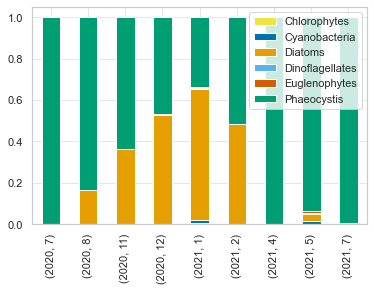

In [17]:
# Convert the index to datetime
results_df.index = pd.to_datetime(results_df.index.str[:7], format="%Y_%m")
# Group the results by year and month
results_df = results_df.groupby([results_df.index.year, results_df.index.month]).mean()

import matplotlib.pyplot as plt

# Define a color dictionary
colors = {
    "Diatoms": "#E69F00",
    "Dinoflagellates": "#56B4E9",
    "Phaeocystis": "#009E73",
    "Chlorophytes": "#F0E442",
    "Cyanobacteria": "#0072B2",
    "Euglenophytes": "#D55E00"
}

# Create a new figure and an axes
fig, ax = plt.subplots()

# Plot the data
results_df.plot(kind='bar', stacked=True, color=[colors.get(x) for x in results_df.columns], ax=ax)

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Show the legend
plt.legend()

# Save the plot
fig.savefig('../../figures/environmental/pigments/stacked_CHEMTAX_barplot.svg', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()
